# Flow Orientation-Based Motion Detection

This notebook implements **scale-invariant motion detection** using flow orientation (direction) instead of magnitude.

## Key Insight
- **Flow magnitude** depends on object distance: nearby objects move more pixels than distant ones
- **Flow orientation** (direction) is independent of distance: a laterally moving object produces flow vectors pointing in a direction that violates the expected camera motion pattern

## Why This Works
When the camera moves, all static scene points produce optical flow following a geometric pattern:
- Pure rotation: flow vectors follow a rotation field
- Translation: flow vectors radiate from/toward the Focus of Expansion (FoE)
- General motion: combination captured by homography

**Moving objects violate this pattern** - their flow direction deviates from the expected direction regardless of their size or distance.

## Approach
1. Compute dense optical flow
2. Estimate expected flow field from camera motion (homography)
3. Compute angular deviation between actual and expected flow
4. Threshold on angle (15-30°) instead of magnitude
5. Objects with high angular deviation = independently moving

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
# Configuration
VIDEO_PATH = 'data/videos/jets_1.mp4'
OUTPUT_DIR = 'data/flow_orientation_frames'
FLOW_VIS_DIR = 'data/flow_orientation_vis'

# Create output directories
for dir_path in [OUTPUT_DIR, FLOW_VIS_DIR]:
    Path(dir_path).mkdir(parents=True, exist_ok=True)

# Feature detection parameters (for RANSAC homography)
feature_params = dict(
    maxCorners=200,
    qualityLevel=0.01,
    minDistance=30,
    blockSize=7
)

# Lucas-Kanade parameters (for sparse tracking)
lk_params = dict(
    winSize=(21, 21),
    maxLevel=3,
    criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 30, 0.01)
)

# RANSAC parameters
RANSAC_REPROJ_THRESHOLD = 3.0

# Flow orientation parameters
ANGLE_DEVIATION_THRESHOLD = 25.0  # Degrees - flow deviating more than this is flagged
MIN_FLOW_MAGNITUDE = 1.0  # Ignore very small flow vectors (noise)

# Detection parameters
MIN_OBJECT_AREA = 200
MAX_OBJECT_AREA = 100000
MORPH_KERNEL_SIZE = 7

# Valid mask
BORDER_MARGIN = 20

# Sampling
FRAME_SAMPLE_INTERVAL = 5

In [3]:
# ============================================
# Base Functions (Feature Tracking & RANSAC)
# ============================================

def detect_features(gray):
    """Detect Shi-Tomasi features."""
    pts = cv2.goodFeaturesToTrack(gray, **feature_params)
    return pts


def track_features(prev_gray, curr_gray, prev_pts):
    """Track features using Lucas-Kanade."""
    if prev_pts is None or len(prev_pts) == 0:
        return None, None
    
    curr_pts, status, _ = cv2.calcOpticalFlowPyrLK(
        prev_gray, curr_gray, prev_pts, None, **lk_params
    )
    
    if status is not None:
        good_old = prev_pts[status.ravel() == 1]
        good_new = curr_pts[status.ravel() == 1]
        return good_old, good_new
    
    return None, None


def estimate_homography_ransac(old_pts, new_pts):
    """Estimate camera motion as homography using RANSAC."""
    if old_pts is None or len(old_pts) < 4:
        return None
    
    H, _ = cv2.findHomography(
        old_pts, new_pts, cv2.RANSAC, RANSAC_REPROJ_THRESHOLD
    )
    return H


def create_border_mask(shape, margin=20):
    """Create mask excluding border regions."""
    h, w = shape[:2]
    mask = np.ones((h, w), dtype=np.uint8) * 255
    
    if margin > 0:
        mask[:margin, :] = 0
        mask[-margin:, :] = 0
        mask[:, :margin] = 0
        mask[:, -margin:] = 0
    
    return mask

In [4]:
# ============================================
# Dense Optical Flow Computation
# ============================================

def compute_dense_flow_farneback(prev_gray, curr_gray):
    """
    Compute dense optical flow using Farneback method.
    Returns flow field of shape (H, W, 2) where flow[:,:,0] is dx and flow[:,:,1] is dy.
    """
    flow = cv2.calcOpticalFlowFarneback(
        prev_gray, curr_gray,
        None,
        pyr_scale=0.5,
        levels=3,
        winsize=15,
        iterations=3,
        poly_n=5,
        poly_sigma=1.2,
        flags=0
    )
    return flow


def compute_dense_flow_dis(prev_gray, curr_gray):
    """
    Compute dense optical flow using DIS (Dense Inverse Search).
    Faster and often more accurate than Farneback.
    """
    dis = cv2.DISOpticalFlow_create(cv2.DISOPTICAL_FLOW_PRESET_MEDIUM)
    flow = dis.calc(prev_gray, curr_gray, None)
    return flow

In [5]:
# ============================================
# Expected Flow Field from Homography
# ============================================

def compute_expected_flow_from_homography(H, shape):
    """
    Compute the expected optical flow field given a homography.
    
    For each pixel (x, y), the expected new position is H @ [x, y, 1]^T.
    The expected flow is: (new_x - x, new_y - y).
    
    Returns flow field of shape (H, W, 2).
    """
    h, w = shape[:2]
    
    # Create grid of pixel coordinates
    y_coords, x_coords = np.mgrid[0:h, 0:w]
    
    # Homogeneous coordinates
    ones = np.ones_like(x_coords)
    coords = np.stack([x_coords, y_coords, ones], axis=-1).astype(np.float32)
    
    # Reshape for matrix multiplication: (H*W, 3)
    coords_flat = coords.reshape(-1, 3)
    
    # Apply homography: H @ coords^T -> (3, H*W)
    transformed = (H @ coords_flat.T).T  # (H*W, 3)
    
    # Convert from homogeneous (divide by w)
    w_div = transformed[:, 2:3]
    w_div = np.where(np.abs(w_div) < 1e-8, 1e-8, w_div)  # Avoid division by zero
    transformed_xy = transformed[:, :2] / w_div
    
    # Compute flow (new position - old position)
    original_xy = coords_flat[:, :2]
    flow_flat = transformed_xy - original_xy
    
    # Reshape back to image dimensions
    expected_flow = flow_flat.reshape(h, w, 2)
    
    return expected_flow.astype(np.float32)

In [6]:
# ============================================
# Flow Orientation Analysis
# ============================================

def compute_flow_orientation(flow):
    """
    Compute orientation (angle in degrees) of flow vectors.
    Returns angles in range [-180, 180].
    """
    dx = flow[:, :, 0]
    dy = flow[:, :, 1]
    
    # atan2 returns radians in [-pi, pi]
    angles_rad = np.arctan2(dy, dx)
    angles_deg = np.degrees(angles_rad)
    
    return angles_deg


def compute_flow_magnitude(flow):
    """Compute magnitude of flow vectors."""
    dx = flow[:, :, 0]
    dy = flow[:, :, 1]
    magnitude = np.sqrt(dx**2 + dy**2)
    return magnitude


def compute_angular_deviation(actual_flow, expected_flow):
    """
    Compute angular deviation between actual and expected flow.
    
    Returns deviation in degrees [0, 180].
    Small deviation = flow matches expected camera motion.
    Large deviation = flow violates camera motion model (independent motion).
    """
    actual_angle = compute_flow_orientation(actual_flow)
    expected_angle = compute_flow_orientation(expected_flow)
    
    # Angular difference (handle wraparound)
    diff = actual_angle - expected_angle
    
    # Normalize to [-180, 180]
    diff = np.mod(diff + 180, 360) - 180
    
    # Absolute deviation [0, 180]
    deviation = np.abs(diff)
    
    return deviation


def detect_motion_by_orientation(actual_flow, expected_flow, 
                                  angle_threshold=25.0, 
                                  min_magnitude=1.0,
                                  valid_mask=None):
    """
    Detect independently moving regions based on flow orientation deviation.
    
    Args:
        actual_flow: Dense optical flow from frames
        expected_flow: Expected flow from camera motion model
        angle_threshold: Deviation threshold in degrees
        min_magnitude: Minimum flow magnitude to consider (filter noise)
        valid_mask: Mask of valid regions to analyze
    
    Returns:
        motion_mask: Binary mask of detected motion
        deviation_map: Angular deviation at each pixel
    """
    # Compute angular deviation
    deviation = compute_angular_deviation(actual_flow, expected_flow)
    
    # Compute magnitudes
    actual_mag = compute_flow_magnitude(actual_flow)
    expected_mag = compute_flow_magnitude(expected_flow)
    
    # Create motion mask based on orientation
    motion_mask = (
        (deviation > angle_threshold) &  # Flow direction deviates significantly
        (actual_mag > min_magnitude)     # Ignore very small flow (noise)
    ).astype(np.uint8) * 255
    
    # Apply valid mask
    if valid_mask is not None:
        motion_mask = cv2.bitwise_and(motion_mask, motion_mask, mask=valid_mask)
    
    return motion_mask, deviation

In [7]:
# ============================================
# Post-processing and Detection
# ============================================

def morphological_cleanup(mask, kernel_size=7):
    """Apply morphological operations to clean up mask."""
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    
    # Close - fill holes
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    # Open - remove noise
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    
    return mask


def extract_bounding_boxes(mask, min_area=200, max_area=100000):
    """Extract bounding boxes from binary mask."""
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask)
    
    detections = []
    for i in range(1, num_labels):
        area = stats[i, cv2.CC_STAT_AREA]
        
        if min_area < area < max_area:
            x = stats[i, cv2.CC_STAT_LEFT]
            y = stats[i, cv2.CC_STAT_TOP]
            w = stats[i, cv2.CC_STAT_WIDTH]
            h = stats[i, cv2.CC_STAT_HEIGHT]
            centroid = tuple(map(int, centroids[i]))
            
            detections.append({
                'bbox': (x, y, w, h),
                'centroid': centroid,
                'area': area
            })
    
    return detections


def draw_detections(frame, detections):
    """Draw bounding boxes on frame."""
    output = frame.copy()
    
    for det in detections:
        x, y, w, h = det['bbox']
        cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.circle(output, det['centroid'], 5, (0, 0, 255), -1)
        cv2.putText(output, f"A:{det['area']}", (x, y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
    
    return output

In [8]:
# ============================================
# Visualization Functions
# ============================================

def visualize_flow_hsv(flow, max_magnitude=None):
    """
    Visualize optical flow using HSV color coding.
    Hue = direction, Saturation = 1, Value = magnitude.
    """
    h, w = flow.shape[:2]
    hsv = np.zeros((h, w, 3), dtype=np.uint8)
    
    mag = compute_flow_magnitude(flow)
    ang = compute_flow_orientation(flow)
    
    # Normalize magnitude
    if max_magnitude is None:
        max_magnitude = np.percentile(mag, 99) + 1e-5
    
    # HSV: H=angle (0-180 for OpenCV), S=255, V=magnitude
    hsv[..., 0] = ((ang + 180) / 2).astype(np.uint8)  # Map [-180,180] to [0,180]
    hsv[..., 1] = 255
    hsv[..., 2] = np.clip(mag / max_magnitude * 255, 0, 255).astype(np.uint8)
    
    rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return rgb


def visualize_deviation_map(deviation, threshold=25.0):
    """
    Visualize angular deviation map.
    Blue = small deviation (matches camera motion).
    Red = large deviation (independent motion).
    """
    # Normalize to 0-255
    norm_dev = np.clip(deviation / 90.0 * 255, 0, 255).astype(np.uint8)
    
    # Apply colormap (blue to red)
    colored = cv2.applyColorMap(norm_dev, cv2.COLORMAP_JET)
    
    return colored

In [9]:
# ============================================
# Main Processing Pipeline
# ============================================

def process_video_orientation(video_path, flow_method='dis'):
    """
    Process video using flow orientation-based motion detection.
    
    Args:
        video_path: Path to input video
        flow_method: 'dis' (faster) or 'farneback'
    """
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print(f"Error: Cannot open video {video_path}")
        return
    
    ret, prev_frame = cap.read()
    if not ret:
        print("Error: Cannot read first frame")
        return
    
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    prev_pts = detect_features(prev_gray)
    
    frame_count = 0
    saved_count = 0
    
    print(f"Processing video with flow orientation method...")
    print(f"Dense flow: {flow_method}")
    print(f"Angle threshold: {ANGLE_DEVIATION_THRESHOLD}°")
    print(f"Min flow magnitude: {MIN_FLOW_MAGNITUDE}")
    print()
    
    while True:
        ret, curr_frame = cap.read()
        if not ret:
            break
        
        frame_count += 1
        curr_gray = cv2.cvtColor(curr_frame, cv2.COLOR_BGR2GRAY)
        
        # Track sparse features for homography estimation
        old_pts, new_pts = track_features(prev_gray, curr_gray, prev_pts)
        
        if old_pts is not None and len(old_pts) >= 4:
            # Estimate camera motion (homography)
            H = estimate_homography_ransac(old_pts, new_pts)
            
            if H is not None:
                # Compute dense optical flow
                if flow_method == 'dis':
                    actual_flow = compute_dense_flow_dis(prev_gray, curr_gray)
                else:
                    actual_flow = compute_dense_flow_farneback(prev_gray, curr_gray)
                
                # Compute expected flow from homography
                expected_flow = compute_expected_flow_from_homography(H, curr_gray.shape)
                
                # Create valid mask (exclude borders)
                valid_mask = create_border_mask(curr_gray.shape, BORDER_MARGIN)
                
                # Detect motion by orientation deviation
                motion_mask, deviation = detect_motion_by_orientation(
                    actual_flow, expected_flow,
                    ANGLE_DEVIATION_THRESHOLD,
                    MIN_FLOW_MAGNITUDE,
                    valid_mask
                )
                
                # Morphological cleanup
                motion_mask = morphological_cleanup(motion_mask, MORPH_KERNEL_SIZE)
                
                # Extract detections
                detections = extract_bounding_boxes(
                    motion_mask, MIN_OBJECT_AREA, MAX_OBJECT_AREA
                )
                
                # Save frames at intervals
                if frame_count % FRAME_SAMPLE_INTERVAL == 0:
                    output_frame = draw_detections(curr_frame, detections)
                    
                    cv2.imwrite(
                        f"{OUTPUT_DIR}/frame_{saved_count:04d}.png",
                        output_frame
                    )
                    
                    # Save deviation visualization
                    dev_vis = visualize_deviation_map(deviation, ANGLE_DEVIATION_THRESHOLD)
                    cv2.imwrite(
                        f"{FLOW_VIS_DIR}/deviation_{saved_count:04d}.png",
                        dev_vis
                    )
                    
                    avg_deviation = np.mean(deviation[valid_mask > 0])
                    print(f"Frame {frame_count}: {len(detections)} detections, "
                          f"avg deviation: {avg_deviation:.1f}°")
                    saved_count += 1
        
        # Re-detect features periodically
        if frame_count % 10 == 0 or (new_pts is not None and len(new_pts) < 50):
            prev_pts = detect_features(curr_gray)
        else:
            prev_pts = new_pts.reshape(-1, 1, 2) if new_pts is not None else detect_features(curr_gray)
        
        prev_gray = curr_gray.copy()
    
    cap.release()
    print(f"\nProcessing complete. Saved {saved_count} frames.")
    print(f"Output saved to: {OUTPUT_DIR}")

In [10]:
# Run the orientation-based pipeline
process_video_orientation(VIDEO_PATH, flow_method='dis')

Processing video with flow orientation method...
Dense flow: dis
Angle threshold: 25.0°
Min flow magnitude: 1.0

Frame 5: 10 detections, avg deviation: 3.2°
Frame 10: 13 detections, avg deviation: 4.0°
Frame 15: 6 detections, avg deviation: 7.8°
Frame 20: 16 detections, avg deviation: 3.9°
Frame 25: 11 detections, avg deviation: 4.3°
Frame 30: 16 detections, avg deviation: 5.2°
Frame 35: 2 detections, avg deviation: 37.5°
Frame 40: 8 detections, avg deviation: 6.3°
Frame 45: 6 detections, avg deviation: 5.9°
Frame 50: 6 detections, avg deviation: 5.8°
Frame 55: 2 detections, avg deviation: 8.2°
Frame 60: 1 detections, avg deviation: 13.7°
Frame 65: 0 detections, avg deviation: 39.3°
Frame 70: 2 detections, avg deviation: 9.7°
Frame 75: 8 detections, avg deviation: 12.4°
Frame 80: 7 detections, avg deviation: 7.0°
Frame 85: 0 detections, avg deviation: 6.2°
Frame 90: 2 detections, avg deviation: 5.1°
Frame 95: 8 detections, avg deviation: 4.4°
Frame 100: 0 detections, avg deviation: 2.4

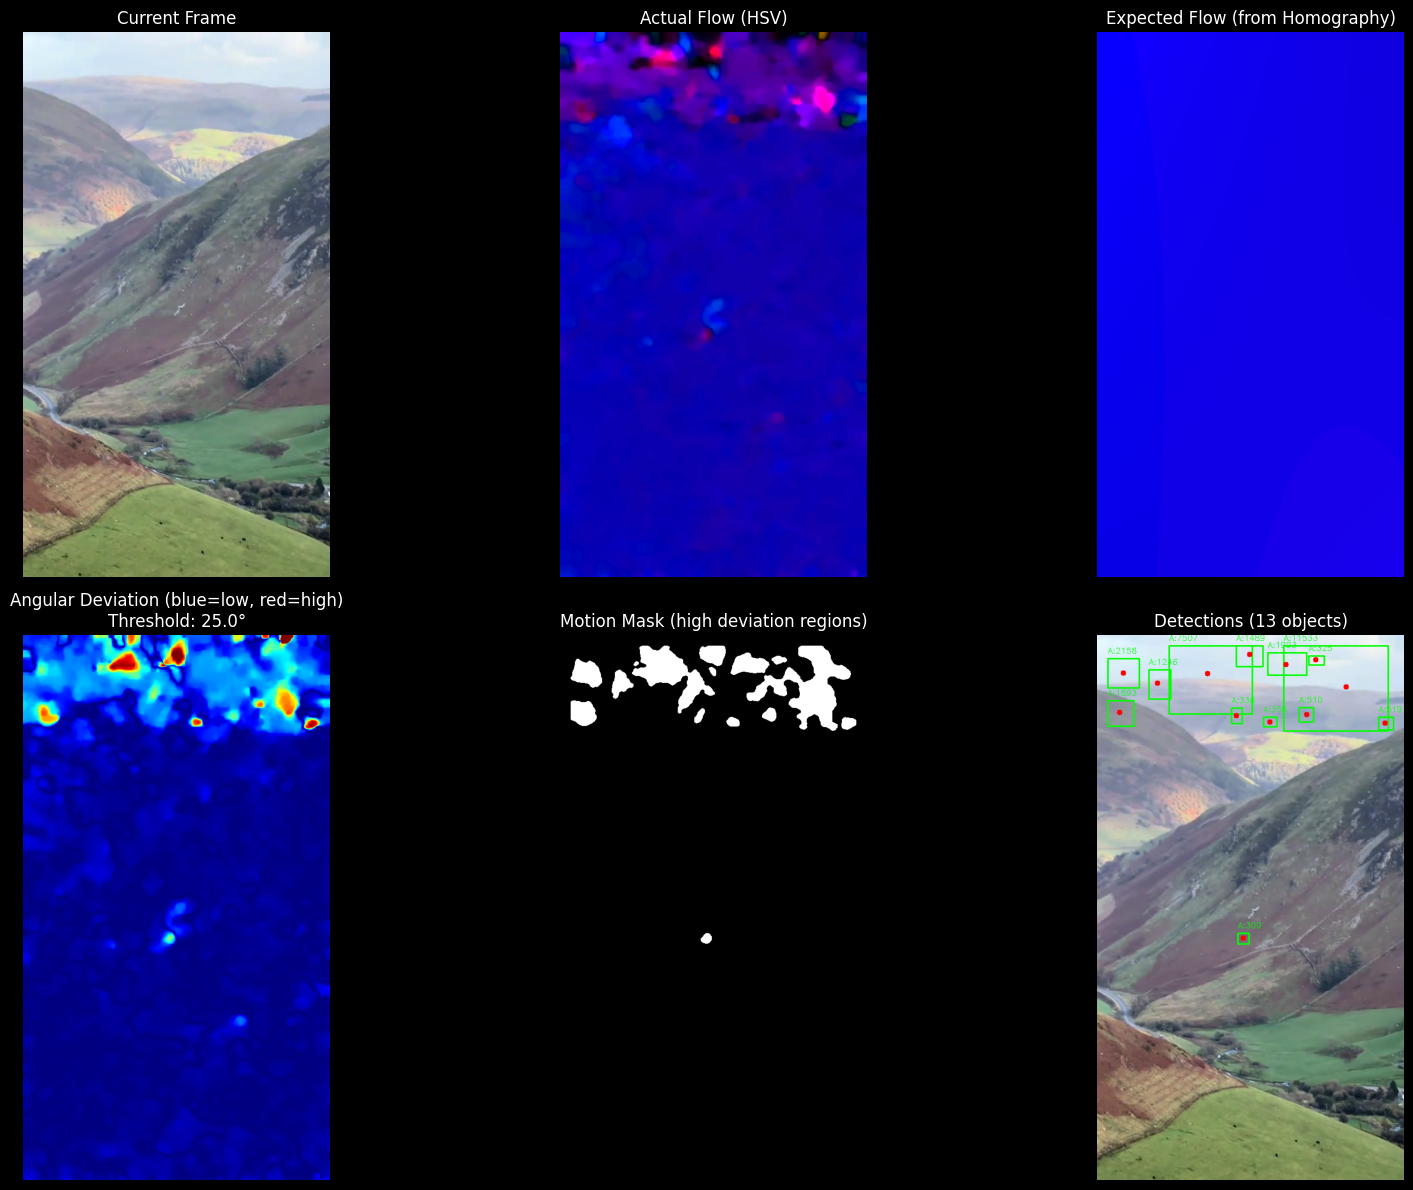


Frame 30 Statistics:
  Mean deviation: 5.3°
  Max deviation: 102.0°
  Pixels above threshold: 35750
  Detections: 13


In [11]:
# ============================================
# Analyze Single Frame in Detail
# ============================================

def analyze_single_frame(video_path, frame_num=30, flow_method='dis'):
    """
    Detailed analysis of a single frame showing:
    - Actual flow
    - Expected flow (from homography)
    - Angular deviation map
    - Detected motion
    """
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num - 1)
    ret, prev_frame = cap.read()
    ret, curr_frame = cap.read()
    cap.release()
    
    if not ret:
        print(f"Cannot read frame {frame_num}")
        return
    
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    curr_gray = cv2.cvtColor(curr_frame, cv2.COLOR_BGR2GRAY)
    
    # Track and estimate homography
    prev_pts = detect_features(prev_gray)
    old_pts, new_pts = track_features(prev_gray, curr_gray, prev_pts)
    H = estimate_homography_ransac(old_pts, new_pts)
    
    if H is None:
        print("Could not estimate homography")
        return
    
    # Compute flows
    if flow_method == 'dis':
        actual_flow = compute_dense_flow_dis(prev_gray, curr_gray)
    else:
        actual_flow = compute_dense_flow_farneback(prev_gray, curr_gray)
    
    expected_flow = compute_expected_flow_from_homography(H, curr_gray.shape)
    
    # Compute deviation and detect motion
    valid_mask = create_border_mask(curr_gray.shape, BORDER_MARGIN)
    motion_mask, deviation = detect_motion_by_orientation(
        actual_flow, expected_flow,
        ANGLE_DEVIATION_THRESHOLD,
        MIN_FLOW_MAGNITUDE,
        valid_mask
    )
    motion_mask = morphological_cleanup(motion_mask, MORPH_KERNEL_SIZE)
    detections = extract_bounding_boxes(motion_mask, MIN_OBJECT_AREA, MAX_OBJECT_AREA)
    
    # Visualize
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Row 1: Flows
    axes[0, 0].imshow(cv2.cvtColor(curr_frame, cv2.COLOR_BGR2RGB))
    axes[0, 0].set_title('Current Frame')
    axes[0, 0].axis('off')
    
    actual_flow_vis = visualize_flow_hsv(actual_flow)
    axes[0, 1].imshow(cv2.cvtColor(actual_flow_vis, cv2.COLOR_BGR2RGB))
    axes[0, 1].set_title('Actual Flow (HSV)')
    axes[0, 1].axis('off')
    
    expected_flow_vis = visualize_flow_hsv(expected_flow)
    axes[0, 2].imshow(cv2.cvtColor(expected_flow_vis, cv2.COLOR_BGR2RGB))
    axes[0, 2].set_title('Expected Flow (from Homography)')
    axes[0, 2].axis('off')
    
    # Row 2: Deviation and detection
    deviation_vis = visualize_deviation_map(deviation, ANGLE_DEVIATION_THRESHOLD)
    axes[1, 0].imshow(cv2.cvtColor(deviation_vis, cv2.COLOR_BGR2RGB))
    axes[1, 0].set_title(f'Angular Deviation (blue=low, red=high)\nThreshold: {ANGLE_DEVIATION_THRESHOLD}°')
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(motion_mask, cmap='gray')
    axes[1, 1].set_title('Motion Mask (high deviation regions)')
    axes[1, 1].axis('off')
    
    output = draw_detections(curr_frame, detections)
    axes[1, 2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    axes[1, 2].set_title(f'Detections ({len(detections)} objects)')
    axes[1, 2].axis('off')
    
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/analysis_frame_{frame_num}.png", dpi=150)
    plt.show()
    
    # Print statistics
    print(f"\nFrame {frame_num} Statistics:")
    print(f"  Mean deviation: {np.mean(deviation[valid_mask > 0]):.1f}°")
    print(f"  Max deviation: {np.max(deviation[valid_mask > 0]):.1f}°")
    print(f"  Pixels above threshold: {np.sum(deviation > ANGLE_DEVIATION_THRESHOLD)}")
    print(f"  Detections: {len(detections)}")

# Analyze a specific frame
analyze_single_frame(VIDEO_PATH, frame_num=30)

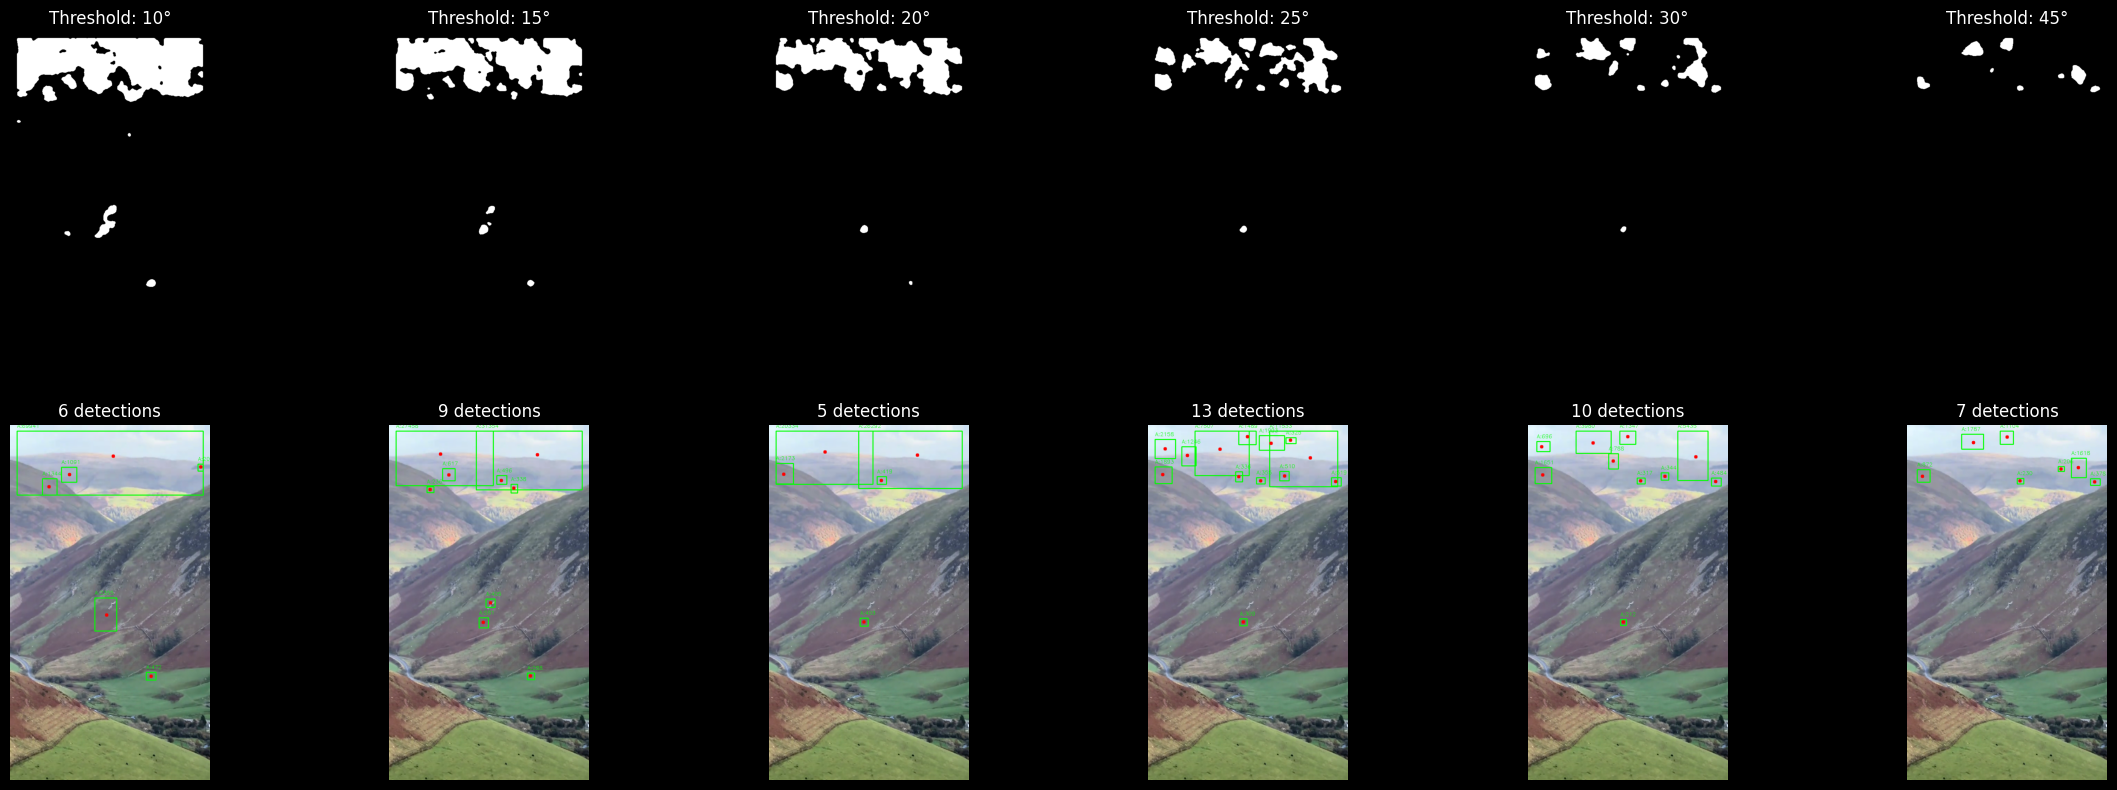

In [12]:
# ============================================
# Test Different Angle Thresholds
# ============================================

def test_angle_thresholds(video_path, frame_num=30, thresholds=[10, 15, 20, 25, 30, 45]):
    """
    Test different angle deviation thresholds on a single frame.
    """
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num - 1)
    ret, prev_frame = cap.read()
    ret, curr_frame = cap.read()
    cap.release()
    
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    curr_gray = cv2.cvtColor(curr_frame, cv2.COLOR_BGR2GRAY)
    
    prev_pts = detect_features(prev_gray)
    old_pts, new_pts = track_features(prev_gray, curr_gray, prev_pts)
    H = estimate_homography_ransac(old_pts, new_pts)
    
    actual_flow = compute_dense_flow_dis(prev_gray, curr_gray)
    expected_flow = compute_expected_flow_from_homography(H, curr_gray.shape)
    valid_mask = create_border_mask(curr_gray.shape, BORDER_MARGIN)
    
    # Compute deviation once
    deviation = compute_angular_deviation(actual_flow, expected_flow)
    actual_mag = compute_flow_magnitude(actual_flow)
    
    fig, axes = plt.subplots(2, len(thresholds), figsize=(4*len(thresholds), 8))
    
    for i, thresh in enumerate(thresholds):
        # Create motion mask for this threshold
        motion_mask = (
            (deviation > thresh) &
            (actual_mag > MIN_FLOW_MAGNITUDE)
        ).astype(np.uint8) * 255
        motion_mask = cv2.bitwise_and(motion_mask, motion_mask, mask=valid_mask)
        motion_mask = morphological_cleanup(motion_mask, MORPH_KERNEL_SIZE)
        
        detections = extract_bounding_boxes(motion_mask, MIN_OBJECT_AREA, MAX_OBJECT_AREA)
        
        # Show mask
        axes[0, i].imshow(motion_mask, cmap='gray')
        axes[0, i].set_title(f"Threshold: {thresh}°")
        axes[0, i].axis('off')
        
        # Show detections
        output = draw_detections(curr_frame, detections)
        axes[1, i].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
        axes[1, i].set_title(f"{len(detections)} detections")
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/threshold_comparison.png", dpi=150)
    plt.show()

test_angle_thresholds(VIDEO_PATH, frame_num=30)

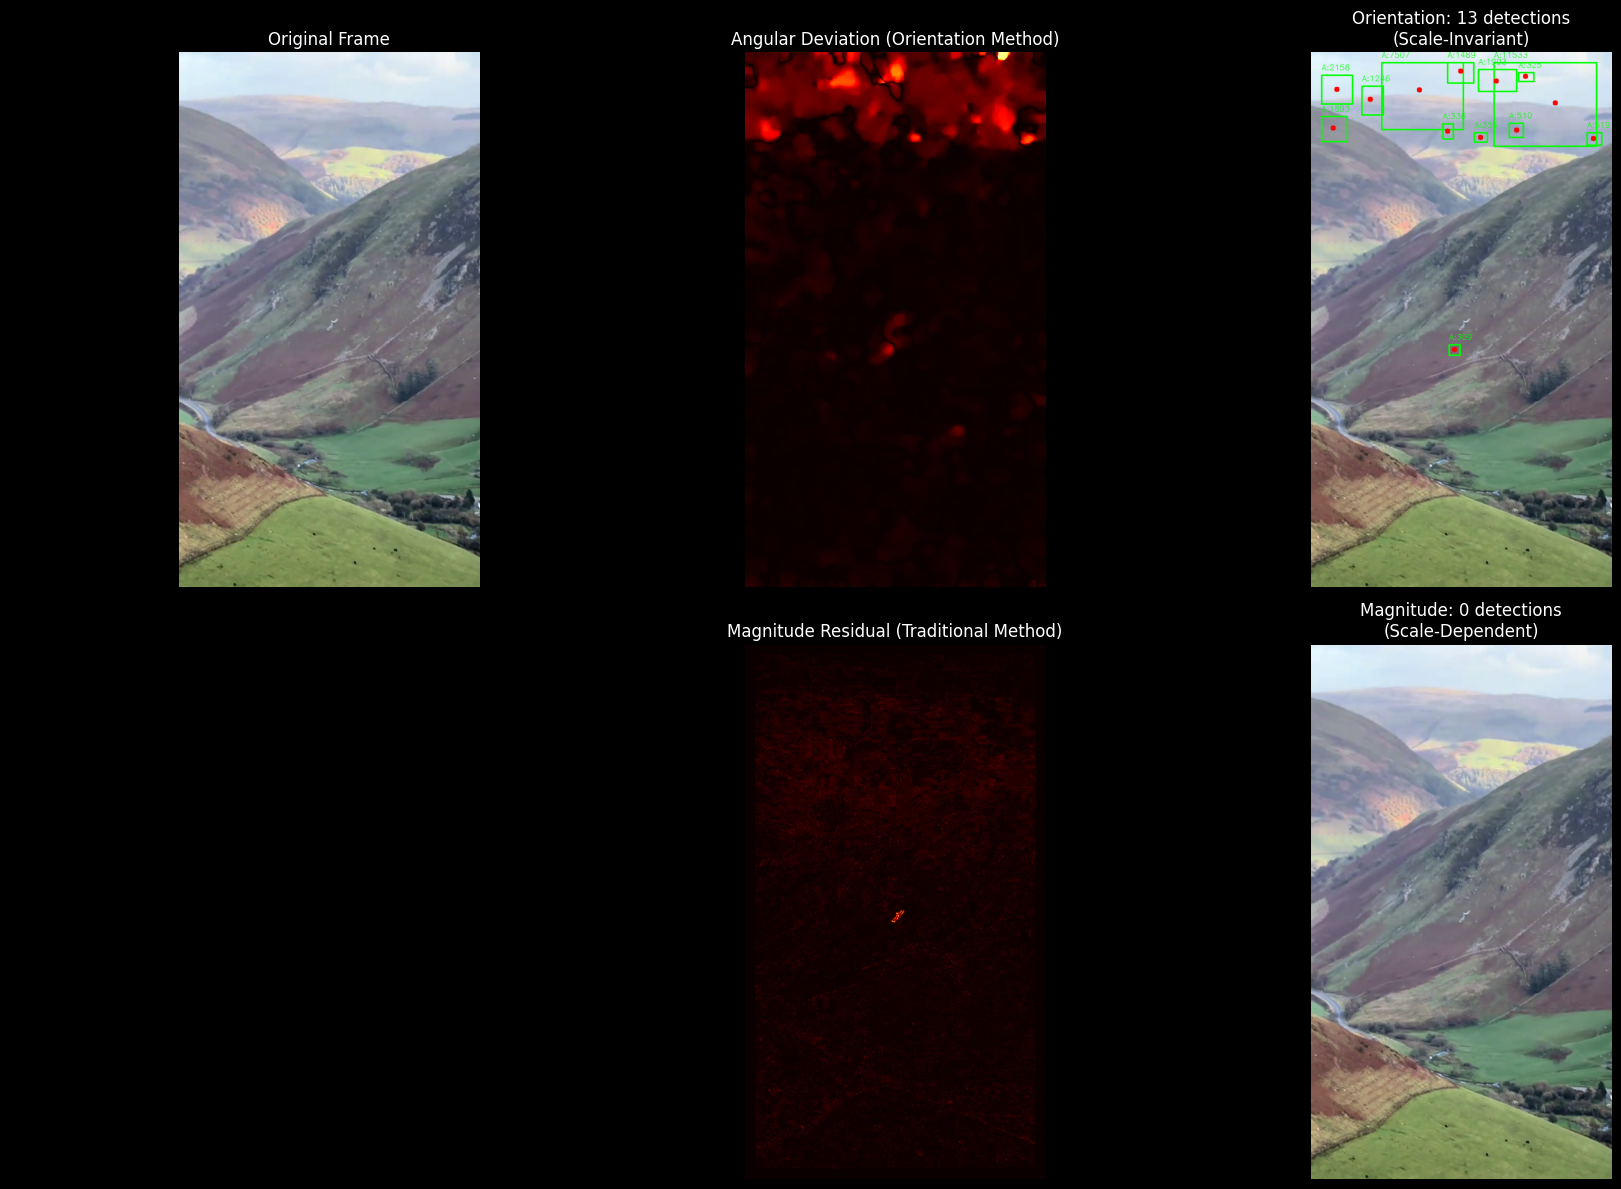

Orientation method: 13 detections (scale-invariant)
Magnitude method: 0 detections (scale-dependent)


In [13]:
# ============================================
# Compare Orientation vs Magnitude
# ============================================

def compare_orientation_vs_magnitude(video_path, frame_num=30):
    """
    Compare orientation-based detection vs traditional magnitude-based residual.
    """
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num - 1)
    ret, prev_frame = cap.read()
    ret, curr_frame = cap.read()
    cap.release()
    
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    curr_gray = cv2.cvtColor(curr_frame, cv2.COLOR_BGR2GRAY)
    
    prev_pts = detect_features(prev_gray)
    old_pts, new_pts = track_features(prev_gray, curr_gray, prev_pts)
    H = estimate_homography_ransac(old_pts, new_pts)
    
    # Method 1: Orientation-based
    actual_flow = compute_dense_flow_dis(prev_gray, curr_gray)
    expected_flow = compute_expected_flow_from_homography(H, curr_gray.shape)
    valid_mask = create_border_mask(curr_gray.shape, BORDER_MARGIN)
    
    orientation_mask, deviation = detect_motion_by_orientation(
        actual_flow, expected_flow,
        ANGLE_DEVIATION_THRESHOLD,
        MIN_FLOW_MAGNITUDE,
        valid_mask
    )
    orientation_mask = morphological_cleanup(orientation_mask, MORPH_KERNEL_SIZE)
    orientation_detections = extract_bounding_boxes(orientation_mask, MIN_OBJECT_AREA, MAX_OBJECT_AREA)
    
    # Method 2: Magnitude-based residual (traditional)
    warped_prev = cv2.warpPerspective(prev_gray, H, (prev_gray.shape[1], prev_gray.shape[0]))
    warp_mask = (warped_prev > 0).astype(np.uint8) * 255
    warp_mask = cv2.erode(warp_mask, np.ones((15, 15), np.uint8))
    warp_mask = cv2.bitwise_and(warp_mask, valid_mask)
    
    residual = cv2.absdiff(curr_gray, warped_prev)
    residual = cv2.bitwise_and(residual, residual, mask=warp_mask)
    
    # Threshold residual
    valid_pixels = residual[warp_mask > 0]
    if len(valid_pixels) > 0:
        median_val = np.median(valid_pixels)
        mad = np.median(np.abs(valid_pixels.astype(np.float32) - median_val))
        thresh = median_val + 3.0 * mad * 1.4826
        thresh = max(thresh, 15)
    else:
        thresh = 15
    
    _, magnitude_mask = cv2.threshold(residual, thresh, 255, cv2.THRESH_BINARY)
    magnitude_mask = cv2.bitwise_and(magnitude_mask, magnitude_mask, mask=warp_mask)
    magnitude_mask = morphological_cleanup(magnitude_mask, MORPH_KERNEL_SIZE)
    magnitude_detections = extract_bounding_boxes(magnitude_mask, MIN_OBJECT_AREA, MAX_OBJECT_AREA)
    
    # Visualize comparison
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    axes[0, 0].imshow(cv2.cvtColor(curr_frame, cv2.COLOR_BGR2RGB))
    axes[0, 0].set_title('Original Frame')
    axes[0, 0].axis('off')
    
    # Orientation method
    axes[0, 1].imshow(deviation, cmap='hot')
    axes[0, 1].set_title('Angular Deviation (Orientation Method)')
    axes[0, 1].axis('off')
    
    orientation_output = draw_detections(curr_frame, orientation_detections)
    axes[0, 2].imshow(cv2.cvtColor(orientation_output, cv2.COLOR_BGR2RGB))
    axes[0, 2].set_title(f'Orientation: {len(orientation_detections)} detections\n(Scale-Invariant)')
    axes[0, 2].axis('off')
    
    # Magnitude method
    axes[1, 1].imshow(residual, cmap='hot')
    axes[1, 1].set_title('Magnitude Residual (Traditional Method)')
    axes[1, 1].axis('off')
    
    magnitude_output = draw_detections(curr_frame, magnitude_detections)
    axes[1, 2].imshow(cv2.cvtColor(magnitude_output, cv2.COLOR_BGR2RGB))
    axes[1, 2].set_title(f'Magnitude: {len(magnitude_detections)} detections\n(Scale-Dependent)')
    axes[1, 2].axis('off')
    
    axes[1, 0].axis('off')
    
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/orientation_vs_magnitude.png", dpi=150)
    plt.show()
    
    print(f"Orientation method: {len(orientation_detections)} detections (scale-invariant)")
    print(f"Magnitude method: {len(magnitude_detections)} detections (scale-dependent)")

compare_orientation_vs_magnitude(VIDEO_PATH, frame_num=30)

## How Flow Orientation Detection Works

### The Scale Problem with Magnitude
Traditional magnitude-based detection:
- **Nearby objects**: Large pixel displacement → easily detected
- **Distant objects**: Small pixel displacement → might miss detection
- Requires different thresholds for different object distances

### Why Orientation is Scale-Invariant
Flow **direction** depends only on motion direction, not distance:
- Object moving left → flow vectors point left (regardless of distance)
- Object moving up → flow vectors point up (regardless of distance)
- Only the **magnitude** changes with distance, not the angle

### The Algorithm
1. **Compute actual flow**: Dense optical flow between frames (DIS or Farneback)
2. **Compute expected flow**: For each pixel, predict where it should move based on homography
3. **Compare angles**: For each pixel, compute angular deviation between actual and expected flow
4. **Threshold on angle**: Pixels with deviation > threshold (25°) are flagged as moving

### Limitations
- **Parallel motion**: Objects moving in the same direction as camera motion produce small angular deviation
- **Requires sufficient flow**: Very slow-moving objects may not produce enough flow to analyze
- **Homography assumption**: Works best when camera motion is well-modeled by homography

### Key Parameters
- `ANGLE_DEVIATION_THRESHOLD`: Default 25°. Lower = more sensitive, higher = fewer false positives
- `MIN_FLOW_MAGNITUDE`: Ignore pixels with very small flow (likely noise)